<a href="https://colab.research.google.com/github/cmunozcortes/c247-final-project/blob/main/src/C247_Final_Notebook_(SCNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SCNN Model
This model is based on the work by Kostas _et_ _al_ on "[Machine Learning for MEG during speech tasks](https://www.nature.com/articles/s41598-019-38612-9)."

### Imports and Global Configuration

In [1]:
import datetime

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, initializers, regularizers
import tensorflow.keras.backend as K

# fix CUDNN_STATUS_INTERNAL_ERROR
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Perform PCA
do_pca = False

# Data loading
- Converts to 32-bit floats to reduce training time
- Adjusts labels to be in the range \[0-3\]
- Generates onehot encoded copies of all values that represent a class index

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/c247")

# Load the data and convert from 64 to 32 bit floats
X_train_valid = np.load("data/X_train_valid.npy").astype(np.float32)
y_train_valid = np.load("data/y_train_valid.npy").astype(np.float32)
person_train_valid = np.load("data/person_train_valid.npy").astype(np.float32)
X_test = np.load("data/X_test.npy").astype(np.float32)
y_test = np.load("data/y_test.npy").astype(np.float32)
person_test = np.load("data/person_test.npy").astype(np.float32)

# Print our the shapes of the data we loaded for confirmation
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

# Function to convert labels from single value class index to onehot vector
def convert_to_one_hot(in_arr):
    in_arr = in_arr.reshape((in_arr.shape[0],))
    in_arr = in_arr.astype(int)
    in_arr_1h = np.zeros((in_arr.size, in_arr.max()+1))
    in_arr_1h[np.arange(in_arr.size),in_arr] = 1
    return in_arr_1h

# Adjust the y labels to be in the range [0-3] and also generate equivalent onehot representations
y_train_valid -= 769
y_test -= 769
print('y_train_valid:', y_train_valid[:10])
print('y_test:', y_train_valid[:10])
y_train_valid_1h = convert_to_one_hot(y_train_valid)
y_test_1h = convert_to_one_hot(y_test)
person_train_valid_1h = convert_to_one_hot(person_train_valid) # TODO remove?
person_test_1h = convert_to_one_hot(person_test) # TODO remove?
print('y_train_valid_1h:')
print(y_train_valid_1h[:4])
print('y_test_1h:')
print(y_train_valid_1h[:4])

# TODO REVIEW: Do we want to include data regarding subject classification?

Mounted at /content/drive
Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
y_train_valid: [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]
y_test: [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]
y_train_valid_1h:
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
y_test_1h:
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


## Data Standardization

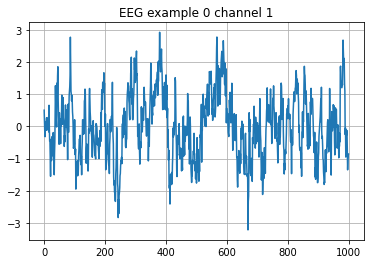

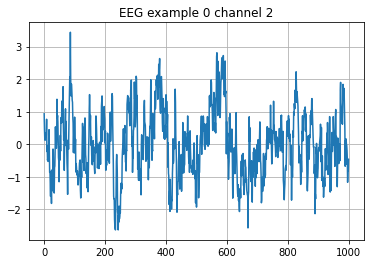

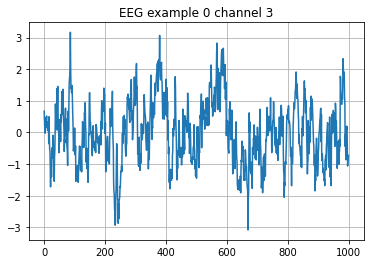

In [3]:
# Normalize each time series signal of each channel to have zero mean and unit variance
# This is fine to do on the test set, since it is independent of example
X_train_valid -= np.expand_dims(np.mean(X_train_valid, axis=-1), -1)
X_test -= np.expand_dims(np.mean(X_test, axis=-1), -1)
X_train_valid /= np.expand_dims(np.std(X_train_valid, axis=-1), -1)
X_test /= np.expand_dims(np.std(X_test, axis=-1), -1)

# Generate some plots to visually verify
for i in range(3):
    plt.title("EEG example 0 channel %d" % (i+1))
    plt.plot(X_train_valid[0,i,:])
    plt.grid()
    plt.show()

## Model Implementation



In [4]:
class ExpandLayer(layers.Layer):

    def __init__(self, axis=-1, **kwargs):
        self.axis = axis
        super(ExpandLayer, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        ax = self.axis
        input_shape = list(input_shape)
        if ax < 0:
            ax = len(input_shape) + ax
        input_shape.insert(ax+1, 1)
        return tuple(input_shape)

    def call(self, inputs, **kwargs):
        return tf.expand_dims(inputs, axis=self.axis)

    def get_config(self):
        return dict(axis=self.axis)

In [5]:
def SCNN(inputshape, outputshape, params=None):

    params = dict() if params is None else params

    temp_layers = int(params.get('temp_layers', 4))
    steps = int(params.get('steps', 2))
    temporal = int(params.get('temporal', 24))
    temp_pool = int(params.get('temp_pool', 20))
    lunits = [int(x) for x in params.get('lunits', [200, 40])]
    activation = params.get('activation', keras.activations.selu)
    reg = float(params.get('regularization', 0.01))
    do = min(1., max(0., float(params.get('dropout', 0.55))))

    convs = [inputshape[-1] // steps for _ in range(1, steps)]
    convs += [inputshape[-1] - sum(convs) + len(convs)]

    ins = keras.layers.Input(inputshape)

    #conv = ExpandLayer()(ins)
    conv = keras.layers.Reshape((inputshape[0], inputshape[1], 1))(ins)

    for i, c in enumerate(convs):
        conv = keras.layers.Conv2D(
            lunits[0] // len(convs), (1, c),
            activation=activation,
            use_bias=False, 
            name='spatial_conv_{0}'.format(i),
            kernel_regularizer=tf.keras.regularizers.l2(reg),
            data_format='channels_last')(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.SpatialDropout2D(do/2)(conv)

    for i in range(temp_layers):
        conv = keras.layers.Conv2D(
            lunits[1], (temporal, 1),
            activation=activation,
            use_bias=False, name='temporal_conv_{0}'.format(i),
            kernel_regularizer=tf.keras.regularizers.l2(reg),
            data_format='channels_last')(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.AveragePooling2D((temp_pool, 1))(conv)
    conv = keras.layers.SpatialDropout2D(do/2)(conv)

    outs = keras.layers.Flatten()(conv)

    for units in lunits[2:]:
        outs = keras.layers.Dense(
            units, activation=activation,
            kernel_regularizer=keras.layers.regularizers.l2(reg))(outs)
        outs = keras.layers.BatchNormalization()(outs)
        outs = keras.layers.Dropout(do)(outs)
    outs = keras.layers.Dense(
        outputshape, activation='softmax', name='OUT',
        kernel_regularizer=tf.keras.regularizers.l2(reg))(outs)

    return keras.models.Model(ins, outs)

Instantiate the model and print a summary of the architecture.

In [6]:
X_train_valid = X_train_valid.transpose((0,2,1))
model = SCNN(inputshape=X_train_valid.shape[1:], outputshape=4)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
reshape (Reshape)            (None, 1000, 22, 1)       0         
_________________________________________________________________
spatial_conv_0 (Conv2D)      (None, 1000, 12, 100)     1100      
_________________________________________________________________
spatial_conv_1 (Conv2D)      (None, 1000, 1, 100)      120000    
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 1, 100)      400       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 1000, 1, 100)      0         
_________________________________________________________________
temporal_conv_0 (Conv2D)     (None, 977, 1, 40)        96000 

In [7]:
# Compile model, using ADAM as the optimizer. Provide a summary once compiled.
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=20, factor=0.5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5', 
        save_best_only=True,
        verbose=True,
        monitor='val_categorical_accuracy'
    ),
]

loss_hist = model.fit(
    X_train_valid, y_train_valid_1h,
    validation_split=0.2,
    batch_size=60,
    epochs=200,
    verbose=2,
    callbacks=callbacks,
)

# Evaluate model on test dataset
print('\nTest accuracy')
print(model.evaluate(X_test.transpose((0,2,1)), y_test_1h))

Epoch 1/200
29/29 - 19s - loss: 4.3822 - categorical_accuracy: 0.3032 - val_loss: 4.1994 - val_categorical_accuracy: 0.3333

Epoch 00001: val_categorical_accuracy improved from -inf to 0.33333, saving model to best_model.h5
Epoch 2/200
29/29 - 1s - loss: 4.2052 - categorical_accuracy: 0.3735 - val_loss: 4.1204 - val_categorical_accuracy: 0.3617

Epoch 00002: val_categorical_accuracy improved from 0.33333 to 0.36170, saving model to best_model.h5
Epoch 3/200
29/29 - 1s - loss: 4.0239 - categorical_accuracy: 0.4427 - val_loss: 4.0669 - val_categorical_accuracy: 0.4184

Epoch 00003: val_categorical_accuracy improved from 0.36170 to 0.41844, saving model to best_model.h5
Epoch 4/200
29/29 - 1s - loss: 3.9240 - categorical_accuracy: 0.4823 - val_loss: 3.9942 - val_categorical_accuracy: 0.4444

Epoch 00004: val_categorical_accuracy improved from 0.41844 to 0.44444, saving model to best_model.h5
Epoch 5/200
29/29 - 1s - loss: 3.8371 - categorical_accuracy: 0.5154 - val_loss: 3.9615 - val_cate

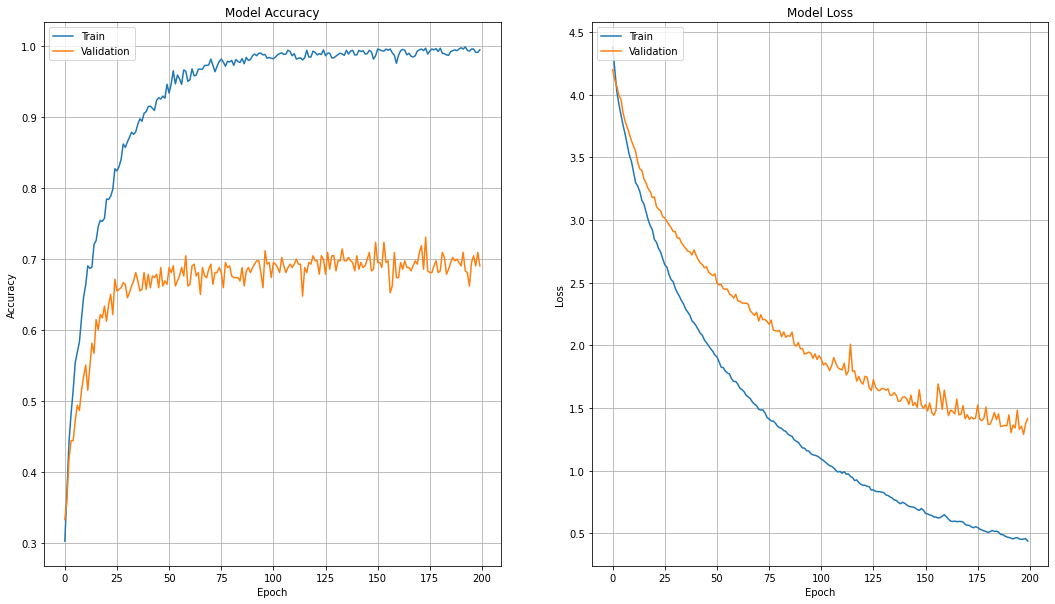

In [8]:
# Plot our loss and accuracy over time
fig, axs = plt.subplots(1,2, figsize=(18, 10))
axs[0].plot(loss_hist.history['categorical_accuracy'])
axs[0].plot(loss_hist.history['val_categorical_accuracy'])
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Model Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper left')
axs[0].grid()
axs[1].plot(loss_hist.history['loss'])
axs[1].plot(loss_hist.history['val_loss'])
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Model Loss')
axs[1].legend(['Train', 'Validation'], loc='upper left')
axs[1].grid()
plt.show()